In [1]:
import google.generativeai as genai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import spacy

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
import utilities

In [3]:
API_KEY = os.environ.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

In [4]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [5]:
a=pd.read_csv('stjohns-embeddings.csv')
a.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'short_name', 'id', 'conversation',
       'flow_id', 'timestamp', 'content', 'failed', 'author', 'Embeddings'],
      dtype='object')

In [6]:
convs = utilities.read_conversations('stjohns-embeddings.csv', remove_stop_words=False)

if 'Embeddings' not in convs.columns:
    convs = utilities.create_embeddings(convs)

convs

,Unnamed: 0.1,Unnamed: 0,short_name,id,conversation,flow_id,timestamp,content,failed,author,Embeddings
0,0,0,stjohns,1,1,F38211883137QDUCKE,2025-01-21T22:25:06.797000Z,What is my GPA?,False,USER,"[0.024404604, -0.05784579, -0.0353709, -0.0248..."
1,1,2,stjohns,3,2,F382118841665YTP21,2025-01-21T22:28:45.996000Z,What is my gpa?,False,USER,"[0.024262685, -0.061454352, -0.044687897, -0.0..."
2,2,4,stjohns,5,2,F672655459266TA1NPW,2025-01-21T22:29:00.041000Z,Who are my advisors?,False,USER,"[0.024339791, -0.026330082, -0.043793313, -0.0..."
3,3,6,stjohns,7,2,F38211884424Z5YG4I,2025-01-21T22:29:17.658000Z,Do I have any holds?,False,USER,"[0.0377827, -0.023452811, -0.057034407, -0.046..."
4,4,8,stjohns,9,2,F38211884697A3JI4V,2025-01-21T22:29:41.216000Z,What is my balance?,False,USER,"[0.017979061, -0.049772903, -0.015351256, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...
1080,1080,2152,stjohns,2153,978,F1019460556921RUUPZ2,2025-03-20T17:30:41.067000Z,how do i switch majors?,False,USER,"[0.024635563, -0.037581913, -0.027746001, -0.0..."
1081,1081,2154,stjohns,2155,979,F10194605608205DK5ZM,2025-03-20T17:34:15.256000Z,medicat,False,USER,"[0.018124312, 0.00995087, -0.043647453, -0.028..."
1082,1082,2156,stjohns,2157,980,F1149031442DZIUJC,2025-03-20T17:39:57.224000Z,transfer student,False,USER,"[0.0119785825, -0.07179161, -0.04670087, -0.00..."
1083,1083,2158,stjohns,2159,981,F147791020235VDM13C,2025-03-20T17:41:32.238000Z,make an appointment with advisor,False,USER,"[0.032656364, -0.038225885, -0.025687905, -0.0..."


In [7]:
convs.iloc[0]['Embeddings']

array([ 2.44046040e-02, -5.78457900e-02, -3.53709000e-02, -2.48232670e-02,
        7.02351700e-02, -4.32465970e-03, -1.15525930e-03, -9.74605000e-03,
        3.63589530e-02, -5.98370240e-03,  3.24114230e-03,  7.48186100e-02,
       -5.76726250e-03, -4.99688400e-02, -1.00023980e-02, -2.88223500e-02,
       -4.22280140e-03, -7.58593750e-02,  4.84341700e-02, -2.39849000e-02,
        1.80981220e-02,  2.95776240e-02, -2.19277850e-02, -2.56910980e-02,
        4.60779480e-02, -2.76730620e-02,  2.70118100e-02, -7.14428000e-02,
       -4.40197400e-02, -3.11395010e-03, -3.95859370e-02,  1.36427380e-02,
       -3.68116050e-02,  2.22816480e-03,  1.76457650e-02, -4.45447340e-02,
        3.06038900e-02, -3.75101400e-02,  8.11221200e-03,  2.86363640e-02,
        2.35044860e-02,  5.47574900e-03, -4.49635600e-02,  3.18805100e-02,
       -1.47796100e-02, -3.38391400e-02,  3.19746770e-02, -2.98936180e-02,
       -1.60287750e-02, -1.54500010e-01,  2.08537540e-02,  8.31595500e-03,
        8.76202060e-02, -

In [8]:
X = np.array(convs['Embeddings'].to_list(), dtype=np.float32)
X.shape

(1085, 768)

In [9]:
X[0]

array([ 2.44046040e-02, -5.78457899e-02, -3.53709012e-02, -2.48232670e-02,
        7.02351704e-02, -4.32465971e-03, -1.15525932e-03, -9.74605046e-03,
        3.63589525e-02, -5.98370237e-03,  3.24114226e-03,  7.48186111e-02,
       -5.76726254e-03, -4.99688387e-02, -1.00023979e-02, -2.88223494e-02,
       -4.22280142e-03, -7.58593753e-02,  4.84341718e-02, -2.39848997e-02,
        1.80981215e-02,  2.95776241e-02, -2.19277851e-02, -2.56910976e-02,
        4.60779481e-02, -2.76730619e-02,  2.70118099e-02, -7.14427978e-02,
       -4.40197401e-02, -3.11395014e-03, -3.95859368e-02,  1.36427376e-02,
       -3.68116051e-02,  2.22816481e-03,  1.76457651e-02, -4.45447341e-02,
        3.06038894e-02, -3.75101417e-02,  8.11221171e-03,  2.86363643e-02,
        2.35044863e-02,  5.47574880e-03, -4.49635610e-02,  3.18805091e-02,
       -1.47796096e-02, -3.38391401e-02,  3.19746770e-02, -2.98936181e-02,
       -1.60287749e-02, -1.54500008e-01,  2.08537541e-02,  8.31595529e-03,
        8.76202062e-02, -

# T-SNE

In [10]:
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [11]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne


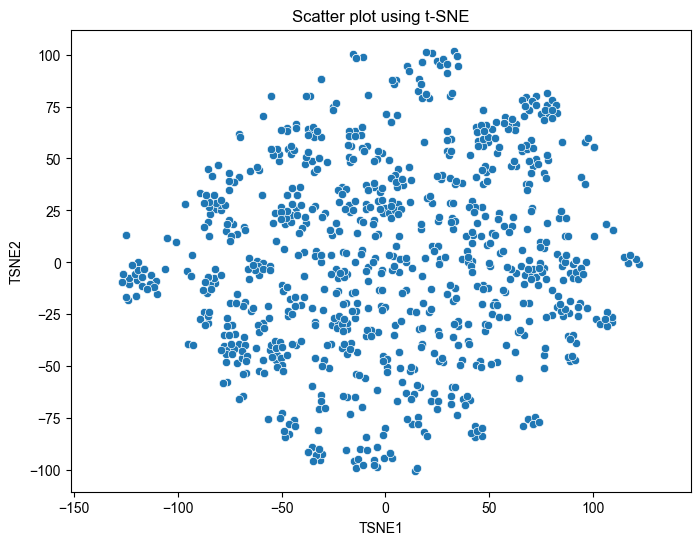

In [12]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2')
plt.title('Scatter plot using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal');

# KMeans

In [13]:
NUM_CLUSTERS = 30

kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)
df_tsne['Cluster'] = labels

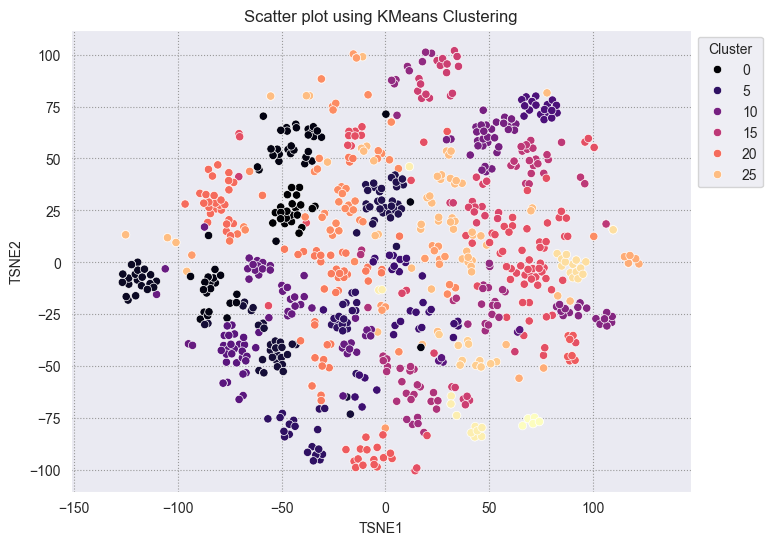

In [14]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal');

In [15]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [16]:
# Print out all of the members of the zeroth cluster
convs[labels == 0]['content'].unique()

array(['how much is the tuition', 'tuition', 'tuition payment', 'fee',
       'tuition fees', 'what is the tuition cost', 'how much is tuition',
       'tuition cost', 'i would like to make a tuition payment',
       'how to pay tuition', 'cost of attendance', 'what is the tuition',
       'pay tuition', 'how much are summer classes', 'fees',
       'the cost of attendance and financial information',
       'whats the tuition'], dtype=object)

In [17]:
# Print out all of the members of the next cluster
convs[labels == 1]['content'].unique()

array(['How do I register for courses?', 'How do you drop a class',
       'how do i register an overnight guest',
       'what is the link for the registrar',
       'how do i register for classes', 'how to i register for classes',
       'i am a new first time student how do i register',
       'how to drop a class', 'when does the spring classes start',
       'registration', 'registrar', 'how do i withdraw from school',
       'drop class', 'Can you tell me the professors for my classes',
       'when does the winter classes start', 'how do i sign up',
       'confirm enrollment', 'How do I become an Orientation Leader',
       'register for orientation', 'when is orientation',
       'what are the course offerings',
       'i have a question about spring classes',
       'where can i find course descriptions',
       'how do i sign up for orientation',
       'how to pay for dual enrollment classes', 'how do i drop a class',
       'how do i sign up for tutoring', 'how to register

In [18]:
# Print out all of the members of the next cluster
convs[labels == 2]['content'].unique()

array(['transcript', 'how do i request a transcript',
       'transcript request', 'transcripts',
       'where can i get my transcript', 'request transcript',
       'i need a transcript', 'request a transcript',
       'i need a copy of my transcript', 'official transcript',
       'i need my transcript', 'order a transcript', 'order transcript',
       'unofficial transcript'], dtype=object)

In [19]:
# Print out all of the members of the next cluster
convs[labels == 3]['content'].unique()

array(['show me the academic calendar', 'what is the final exam schedule',
       'academic calendar', 'school calendar',
       'what is the schedule for the final exams',
       'what is going on with mens basketball season tickets this yera',
       'can you please show me the academic calendar', 'calendar',
       'when does the spring semester start', 'law school calendar',
       'academic calender', 'academic calander', 'course catalog',
       'mens basketball schedule', 'final exam schedule',
       'when does the spring semester starts',
       'academic calendar spring 2024', 'when is spring break',
       'law school academic calendar'], dtype=object)